In [3]:
import pandas_profiling as pp
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

# from sklearn.metrics import ...
# import statsmodels as sm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

# set Jupyter to display ALL output from a cell (not just last output)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# set pandas and numpy options to make print format nicer
pd.set_option("display.width",100)
pd.set_option("display.max_columns",100)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 500)
np.set_printoptions(linewidth=120, threshold=5000, edgeitems=50, suppress=True)

seed = 42
np.random.seed(seed=seed)

In [11]:
filename = 'data/train.csv' # or could be URL

data = pd.read_csv(filename)
assert data.shape[0] == 891, "data file is not 891 rows"

## Describe Data

In [14]:
data.shape
data.info()
data.describe()

pp.ProfileReport(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Number of variables,12
Number of observations,891
Total Missing (%),8.1%
Total size in memory,83.6 KiB
Average record size in memory,96.1 B
Numeric,6
Categorical,4
Boolean,1
Date,0
Text (Unique),1
Rejected,0


# EDA on all fields

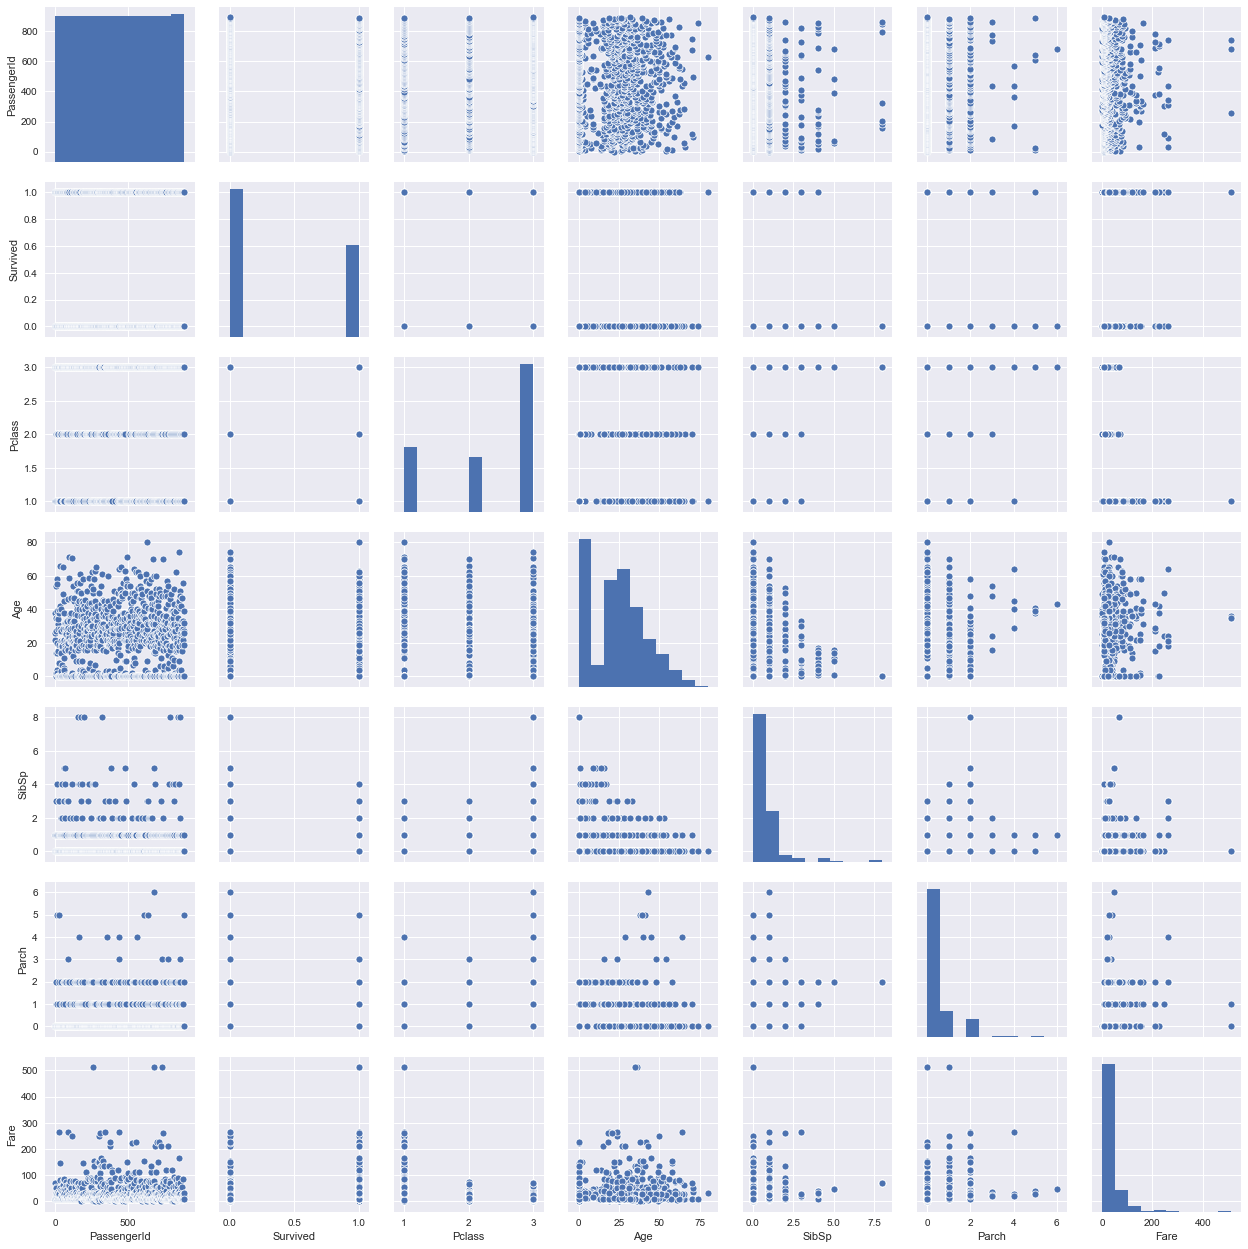

In [23]:
_ = sns.pairplot(data.fillna(0))

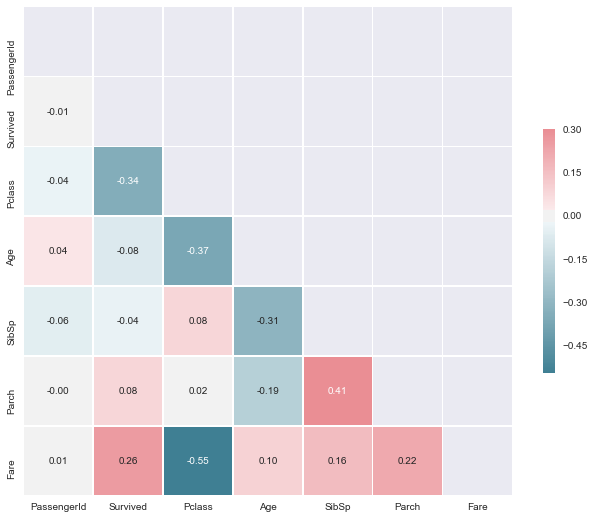

In [21]:
corr = data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(11, 9))

_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Feature Selection

In [25]:
# Lasso/ElasticNet L1 regularisation
# random forest feature importances
# scikit learn feature selection https://scikit-learn.org/stable/modules/feature_selection.html (eg chi2)


# Split train and test

In [37]:
X = data.loc[:, data.columns!='Survived']
y = data.Survived

X = pd.get_dummies(X).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((668, 1730), (668,), (223, 1730), (223,))

# Model Selection

In [59]:
import time
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

models = [
    LogisticRegression(penalty='l2',C=1, random_state=seed),
    RandomForestClassifier(random_state=seed),
    KNeighborsClassifier(n_neighbors=5),
    DecisionTreeClassifier(random_state=seed),
    AdaBoostClassifier(random_state=seed),
    GaussianNB(),
#     LinearDiscriminantAnalysis(),
#     QuadraticDiscriminantAnalysis(),
    
    GradientBoostingClassifier(max_features=None, learning_rate=0.1, n_estimators=100, max_depth=3, 
                           min_samples_leaf=1, subsample=1.0, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, random_state=seed),
    xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, min_child_weight=1, max_depth=3, gamma=0,
                       subsample=1, colsample_bytree=1, reg_lambda=1, reg_alpha=0,  
                       objective= 'binary:logistic', n_jobs=-1, random_state=seed, eval_metric='logloss'),
]

num_models, num_folds = len(models), 10
errors = np.zeros([num_models, num_folds])

for i, model in enumerate(models):
    start_time = time.time()
    _ = model.fit(X_train, y_train)
    errors[i] = cross_val_score(model, X=X_train, y=y_train, cv=num_folds, scoring='roc_auc')
    print('{:26.26}  Runime={:8.2f} seconds, CV Score={:8.5f}'.format(
        type(model).__name__, round(time.time()-start_time,2), np.mean(errors[i])))
    
np.mean(errors, 1)

LogisticRegression          Runime=    0.13 seconds, CV Score= 0.83950
RandomForestClassifier      Runime=    0.27 seconds, CV Score= 0.83861
KNeighborsClassifier        Runime=    0.36 seconds, CV Score= 0.55708
DecisionTreeClassifier      Runime=    0.21 seconds, CV Score= 0.76978
AdaBoostClassifier          Runime=    1.67 seconds, CV Score= 0.82488
GaussianNB                  Runime=    0.17 seconds, CV Score= 0.53054
GradientBoostingClassifier  Runime=    5.45 seconds, CV Score= 0.84134
XGBClassifier               Runime=    4.88 seconds, CV Score= 0.84822


array([0.83950067, 0.83860859, 0.55708327, 0.76977754, 0.82487541, 0.5305448 , 0.84134115, 0.84821697])

# Model Hyperparameter Tuning

In [63]:
from skopt import gp_minimize, gbrt_minimize
from skopt.plots import plot_convergence
import datetime, warnings

def objective(values):    
    index = str(values)
    if index in cache:
        print('GET FROM CACHE:', index, round(cache[index],4))
        return cache[index]
    
    if model_type == 'LogisticRegression':
        params = {'penalty': values[0], 'C': values[1],}
        model = LogisticRegression(**params, random_state=seed, n_jobs=-1)
        
    if model_type == 'RandomForestClassifier':
        params = {'n_estimators': values[0], 'max_features': values[1], 'max_depth': values[2],}
        model = RandomForestClassifier(**params, n_jobs=-1)
    
    if model_type == 'GradientBoostingClassifier':
        params = {'learning_rate': values[0], 'n_estimators': values[1], 'max_depth': values[2],
                  'min_samples_split': values[3], 'min_samples_leaf': values[4], 
                  'min_weight_fraction_leaf' : values[5], 'subsample': values[6], 'max_features': values[7] }
        model = GradientBoostingClassifier(**params, random_state=seed)
    
    if model_type == 'XGBClassifier':
        params = {'learning_rate': values[0], 'n_estimators': int(values[1]), 'min_child_weight': int(values[2]),
                  'max_depth': int(values[3]), 'gamma': values[4], 'subsample': values[5],
                  'colsample_bytree': values[6], 'lambda': values[7], 'alpha': values[8], 'eval_metric':'logloss'}
        model = xgb.XGBClassifier(**params, random_state=seed, nthread=-1, n_jobs=-1,silent=1)
        
    print(datetime.datetime.now().time().replace(microsecond=0), ', Params',params) 
    scores = -cross_val_score(model, X=X_train, y=y_train, scoring="roc_auc", cv=10, n_jobs=-1)
    cache[index] = np.mean( scores )
    return cache[index]

Iteration No: 1 started. Evaluating function at random point.
12:19:25 , Params {'penalty': 'l1', 'C': 32147.19348281704}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.2935
Function value obtained: -0.8029
Current minimum: -0.8029
Iteration No: 2 started. Evaluating function at random point.
12:19:28 , Params {'penalty': 'l2', 'C': 9.695826644515241}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.3771
Function value obtained: -0.8477
Current minimum: -0.8477
Iteration No: 3 started. Evaluating function at random point.
12:19:32 , Params {'penalty': 'l1', 'C': 0.0003630322466779861}
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.3643
Function value obtained: -0.5160
Current minimum: -0.8477
Iteration No: 4 started. Evaluating function at random point.
12:19:35 , Params {'penalty': 'l1', 'C': 4589.458612326484}
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.2054
Function value obtained: -0.8384
C

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 3.3424
Function value obtained: -0.8343
Current minimum: -0.8506
Iteration No: 33 started. Searching for the next optimal point.
12:21:13 , Params {'penalty': 'l2', 'C': 21.394442234283186}
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 3.3010
Function value obtained: -0.8493
Current minimum: -0.8506
Iteration No: 34 started. Searching for the next optimal point.
12:21:16 , Params {'penalty': 'l2', 'C': 38.38837995380077}
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 3.4632
Function value obtained: -0.8502
Current minimum: -0.8506
Iteration No: 35 started. Searching for the next optimal point.
12:21:20 , Params {'penalty': 'l2', 'C': 38.5931496704635}
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 3.5120
Function value obtained: -0.8516
Current minimum: -0.8516
Iteration No: 36 started. Searching for the next

Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 3.5265
Function value obtained: -0.8483
Current minimum: -0.8544
Iteration No: 64 started. Searching for the next optimal point.
12:23:01 , Params {'penalty': 'l2', 'C': 78095.28166997452}
Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 3.5769
Function value obtained: -0.8499
Current minimum: -0.8544
Iteration No: 65 started. Searching for the next optimal point.
12:23:05 , Params {'penalty': 'l2', 'C': 80141.81690999708}
Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 3.5410
Function value obtained: -0.8491
Current minimum: -0.8544
Iteration No: 66 started. Searching for the next optimal point.
12:23:08 , Params {'penalty': 'l1', 'C': 2.1388430199164848e-05}
Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 3.7473
Function value obtained: -0.5000
Current minimum: -0.8544
Iteration No: 67 started. Searching for the

Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 3.3552
Function value obtained: -0.5018
Current minimum: -0.8544
Iteration No: 95 started. Searching for the next optimal point.
12:24:51 , Params {'penalty': 'l1', 'C': 0.00033611212554037986}
Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 3.3684
Function value obtained: -0.5055
Current minimum: -0.8544
Iteration No: 96 started. Searching for the next optimal point.
12:24:54 , Params {'penalty': 'l2', 'C': 0.008170487121440065}
Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 3.3440
Function value obtained: -0.8187
Current minimum: -0.8544
Iteration No: 97 started. Searching for the next optimal point.
12:24:57 , Params {'penalty': 'l2', 'C': 0.008172177528325228}
Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 3.5078
Function value obtained: -0.8190
Current minimum: -0.8544
Iteration No: 98 started. Searching f

Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 3.5255
Function value obtained: -0.8504
Current minimum: -0.8544
Iteration No: 126 started. Searching for the next optimal point.
12:26:37 , Params {'penalty': 'l2', 'C': 78368.7418798296}
Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 3.5329
Function value obtained: -0.8511
Current minimum: -0.8544
Iteration No: 127 started. Searching for the next optimal point.
12:26:41 , Params {'penalty': 'l2', 'C': 79457.57237328617}
Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 3.3464
Function value obtained: -0.8510
Current minimum: -0.8544
Iteration No: 128 started. Searching for the next optimal point.
12:26:44 , Params {'penalty': 'l1', 'C': 6269.005356308513}
Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 3.4377
Function value obtained: -0.8375
Current minimum: -0.8544
Iteration No: 129 started. Searching for t

Iteration No: 156 ended. Search finished for the next optimal point.
Time taken: 3.3552
Function value obtained: -0.8488
Current minimum: -0.8544
Iteration No: 157 started. Searching for the next optimal point.
12:28:22 , Params {'penalty': 'l1', 'C': 12.765354511630079}
Iteration No: 157 ended. Search finished for the next optimal point.
Time taken: 3.3679
Function value obtained: -0.8346
Current minimum: -0.8544
Iteration No: 158 started. Searching for the next optimal point.
12:28:25 , Params {'penalty': 'l2', 'C': 82828.8407808119}
Iteration No: 158 ended. Search finished for the next optimal point.
Time taken: 3.3439
Function value obtained: -0.8513
Current minimum: -0.8544
Iteration No: 159 started. Searching for the next optimal point.
12:28:29 , Params {'penalty': 'l2', 'C': 82917.20138586978}
Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 3.3578
Function value obtained: -0.8498
Current minimum: -0.8544
Iteration No: 160 started. Searching for 

Iteration No: 187 ended. Search finished for the next optimal point.
Time taken: 3.3072
Function value obtained: -0.8519
Current minimum: -0.8544
Iteration No: 188 started. Searching for the next optimal point.
12:30:06 , Params {'penalty': 'l2', 'C': 82065.23775314052}
Iteration No: 188 ended. Search finished for the next optimal point.
Time taken: 3.3751
Function value obtained: -0.8485
Current minimum: -0.8544
Iteration No: 189 started. Searching for the next optimal point.
12:30:09 , Params {'penalty': 'l2', 'C': 81744.489455772}
Iteration No: 189 ended. Search finished for the next optimal point.
Time taken: 3.3428
Function value obtained: -0.8502
Current minimum: -0.8544
Iteration No: 190 started. Searching for the next optimal point.
12:30:13 , Params {'penalty': 'l2', 'C': 38.52999509248372}
Iteration No: 190 ended. Search finished for the next optimal point.
Time taken: 3.3633
Function value obtained: -0.8497
Current minimum: -0.8544
Iteration No: 191 started. Searching for th

Iteration No: 218 ended. Search finished for the next optimal point.
Time taken: 3.3563
Function value obtained: -0.8345
Current minimum: -0.8544
Iteration No: 219 started. Searching for the next optimal point.
12:31:50 , Params {'penalty': 'l1', 'C': 94383.3528179022}
Iteration No: 219 ended. Search finished for the next optimal point.
Time taken: 3.3576
Function value obtained: -0.7964
Current minimum: -0.8544
Iteration No: 220 started. Searching for the next optimal point.
12:31:54 , Params {'penalty': 'l1', 'C': 9.70039804075084}
Iteration No: 220 ended. Search finished for the next optimal point.
Time taken: 3.3720
Function value obtained: -0.8345
Current minimum: -0.8544
Iteration No: 221 started. Searching for the next optimal point.
12:31:57 , Params {'penalty': 'l1', 'C': 79610.41020717559}
Iteration No: 221 ended. Search finished for the next optimal point.
Time taken: 3.3931
Function value obtained: -0.7970
Current minimum: -0.8544
Iteration No: 222 started. Searching for th

Iteration No: 248 ended. Search finished for the next optimal point.
Time taken: 3.3347
Function value obtained: -0.8214
Current minimum: -0.8544
Iteration No: 249 started. Searching for the next optimal point.
12:33:31 , Params {'penalty': 'l2', 'C': 0.007609089090161398}
Iteration No: 249 ended. Search finished for the next optimal point.
Time taken: 3.3275
Function value obtained: -0.8164
Current minimum: -0.8544
Iteration No: 250 started. Searching for the next optimal point.
12:33:34 , Params {'penalty': 'l2', 'C': 0.00759220798762615}
Iteration No: 250 ended. Search finished for the next optimal point.
Time taken: 3.3435
Function value obtained: -0.8164
Current minimum: -0.8544
Iteration No: 251 started. Searching for the next optimal point.
12:33:38 , Params {'penalty': 'l2', 'C': 0.007686398751883579}
Iteration No: 251 ended. Search finished for the next optimal point.
Time taken: 3.3472
Function value obtained: -0.8172
Current minimum: -0.8544
Iteration No: 252 started. Search

Iteration No: 279 ended. Search finished for the next optimal point.
Time taken: 3.4469
Function value obtained: -0.8501
Current minimum: -0.8544
Iteration No: 280 started. Searching for the next optimal point.
12:35:15 , Params {'penalty': 'l2', 'C': 82932.32499721508}
Iteration No: 280 ended. Search finished for the next optimal point.
Time taken: 3.6517
Function value obtained: -0.8497
Current minimum: -0.8544
Iteration No: 281 started. Searching for the next optimal point.
12:35:19 , Params {'penalty': 'l2', 'C': 80532.0057159392}
Iteration No: 281 ended. Search finished for the next optimal point.
Time taken: 3.6517
Function value obtained: -0.8496
Current minimum: -0.8544
Iteration No: 282 started. Searching for the next optimal point.
12:35:23 , Params {'penalty': 'l2', 'C': 82670.66929593834}
Iteration No: 282 ended. Search finished for the next optimal point.
Time taken: 3.6331
Function value obtained: -0.8514
Current minimum: -0.8544
Iteration No: 283 started. Searching for t

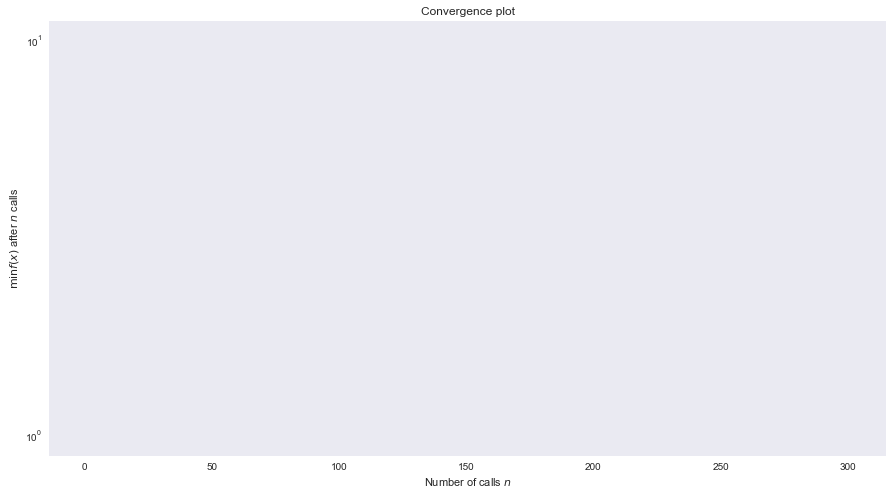

In [67]:
# %%time
import warnings
np.random.seed(seed)
warnings.filterwarnings("ignore", category=UserWarning) # turn off already evaluated errors
params={'LogisticRegression': [ 
                ['l1','l2'],
                (1e-5,1e+5,'log-uniform'),
                ],
        'GradientBoostingClassifier': [ 
                (0.04, 0.10, 'uniform'),     # learning rate
                (500, 900),                  # n_estimators
                (3, 7),                      # max_depth   
                (2, 5),                      # min_samples_split 
                (2, 5),                      # min_samples_leaf 
                (0, 0.3),                    # min_weight_fraction_leaf 
                (0.8, 1.0,'uniform'),        # subsample 
                ('sqrt',),                   # max_features 
                ],
        'XGBClassifier': [
                (0.01, 0.05, 'uniform'),    # learning_rate 0.05, 0.3,
                (300, 700),                 # n_estimators
                (5, 9),                     # min_child_weight 
                (4, 8),                     # max_depth 3-10
                (0, 0.5,   'uniform'),      # gamma 0-0.4
                (0.4, 1.0, 'uniform'),      # subsample 0.5 - 0.99
                (0.8, 1.0, 'uniform'),      # colsample_bytree 0.5 - 0.99
                (0.8, 1.0, 'uniform'),      # reg_lambda
                (0.0, 0.5, 'uniform'),      # reg_alpha
                ],}


model_types = params.keys()
model_types = ['LogisticRegression']
for model_type in model_types:
    cache = {}
    space = params[model_type]
    result = gbrt_minimize(objective,space,n_random_starts=10, n_calls=200, random_state=seed,verbose=True,n_jobs=-1)
    print('\n', model_type, ', Best Params=', result.x, ' Best Score=', round(result.fun,6),'\n')
    _ = plt.figure(figsize=(15,8))
    _ = plot_convergence(result, yscale='log')

warnings.filterwarnings("default", category=UserWarning) # turn on already evaluated errors

In [69]:
# show best results
sorted_d = sorted(cache.items(), key=lambda x: x[1])
temp = []
for i in range(len(sorted_d)):
    temp.append((sorted_d[i][0], round(sorted_d[i][1],5)))
    print('{} {}'.format(round(sorted_d[i][1],5), sorted_d[i][0]))

-0.85439 ['l2', 78372.78859656781]
-0.85272 ['l2', 83086.05900895131]
-0.85268 ['l2', 81539.34492727561]
-0.85268 ['l2', 78310.97598900004]
-0.85239 ['l2', 80888.89594363894]
-0.85234 ['l2', 79112.62478613779]
-0.85211 ['l2', 83227.03969176523]
-0.85205 ['l2', 80790.89289078479]
-0.85204 ['l2', 82065.9950518608]
-0.85199 ['l2', 80169.44597382039]
-0.85188 ['l2', 83472.89719764923]
-0.85162 ['l2', 82361.00006259287]
-0.85161 ['l2', 79076.95708634246]
-0.8516 ['l2', 38.5931496704635]
-0.85158 ['l2', 83151.28764402718]
-0.85155 ['l2', 96899.67668571889]
-0.85154 ['l2', 78351.48005448197]
-0.85147 ['l2', 78867.39819654528]
-0.85143 ['l2', 82670.66929593834]
-0.85141 ['l2', 80782.5215784283]
-0.85133 ['l2', 82828.8407808119]
-0.85124 ['l2', 78292.40416854387]
-0.8512 ['l2', 78322.31853548728]
-0.85118 ['l2', 82855.17110857776]
-0.85115 ['l2', 83276.55745780314]
-0.85109 ['l2', 80887.59344896513]
-0.85109 ['l2', 78368.7418798296]
-0.85105 ['l2', 95947.6217947125]
-0.85102 ['l2', 79457.572373

# Unit Tests
Consider adding unit/data tests